In [1]:
MODE = "MOUNT"
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Gan_project.zip" -d "/content/drive/MyDrive/images/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/images/images/62764_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62765_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62766_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62767_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62768_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62769_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/6276_2003.jpg  
  inflating: /content/drive/MyDrive/images/images/62770_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62771_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62772_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62773_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62774_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62775_2019.jpg  
  inflating: /content/drive/MyDrive/images/images/62776_2019.jpg  
  inflating:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm
import os
import torch as t
import torch.backends.cudnn as cud
import torch.optim as opt
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as tnf

random.seed(1000)
t.manual_seed(1000)

In [4]:
images = datasets.ImageFolder(root='/content/drive/MyDrive/images/',
                                transform=transforms.Compose([
                                    transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5, std=0.5)
                                ]))

dataloader = t.utils.data.DataLoader(images, batch_size=128, shuffle=True)


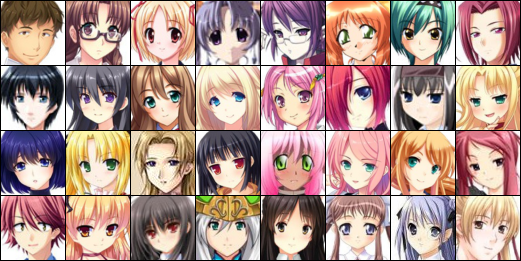

In [7]:
device = t.device("cuda:0" if (t.cuda.is_available() and 1 > 0) else "cpu")
imgs = next(iter(dataloader))
fig = px.imshow(np.transpose(utils.make_grid(imgs[0].to(device)[:32], padding=1, normalize=True).cpu(),(1,2,0)))
fig.show()

In [14]:
n=64

In [15]:
class Discriminator(nn.Module):
    def __init__(self, n_channels=n):
        super().__init__()

        self.n = n_channels
        self.C1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=4, stride=2, padding=1)
        self.C2 = nn.Conv2d(in_channels=self.n, out_channels=self.n*2, kernel_size=4, stride=2, padding=1)
        self.C3 = nn.Conv2d(in_channels=self.n*2, out_channels=self.n*4, kernel_size=4, stride=2, padding=1)
        self.C4 = nn.Conv2d(in_channels=self.n*4, out_channels=self.n*8, kernel_size=4, stride=2, padding=1)
        self.C5 = nn.Conv2d(in_channels=self.n*8, out_channels=1, kernel_size=4, stride=2, padding=0)

        self.N1 = nn.BatchNorm2d(self.n)
        self.N2 = nn.BatchNorm2d(self.n*2)
        self.N3 = nn.BatchNorm2d(self.n*4)
        self.N4 = nn.BatchNorm2d(self.n*8)

        self.A = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.F = nn.Flatten()
        self.S = nn.Sigmoid()

        self.model = nn.Sequential(
                self.C1, self.N1, self.A,
                self.C2, self.N2, self.A,
                self.C3, self.N3, self.A,
                self.C4, self.N4, self.A,
                self.C5, self.F, self.S)

    def forward(self, dataset):
        return self.model(dataset)

dis = Discriminator().to(device)

In [16]:
class Generator(nn.Module):
    def __init__(self, n_channels=n):
        super().__init__()

        self.n = n_channels
        self.C1 = nn.ConvTranspose2d(in_channels=100, out_channels=self.n*8, kernel_size=4, stride=2, padding=0)
        self.C2 = nn.ConvTranspose2d(in_channels=self.n*8, out_channels=self.n*4, kernel_size=4, stride=2, padding=1)
        self.C3 = nn.ConvTranspose2d(in_channels=self.n*4, out_channels=self.n*2, kernel_size=4, stride=2, padding=1)
        self.C4 = nn.ConvTranspose2d(in_channels=self.n*2, out_channels=self.n, kernel_size=4, stride=2, padding=1)
        self.C5 = nn.ConvTranspose2d(in_channels=self.n, out_channels=3, kernel_size=4, stride=2, padding=1)

        self.N1 = nn.BatchNorm2d(self.n*8)
        self.N2 = nn.BatchNorm2d(self.n*4)
        self.N3 = nn.BatchNorm2d(self.n*2)
        self.N4 = nn.BatchNorm2d(self.n)

        self.A = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.T = nn.Tanh()

        self.model = nn.Sequential(
                self.C1, self.N1, self.A,
                self.C2, self.N2, self.A,
                self.C3, self.N3, self.A,
                self.C4, self.N4, self.A,
                self.C5, self.T)

    def forward(self, dataset):
        return self.model(dataset)

gen = Generator().to(device)

In [17]:
def dis_train(dataset, dis_opt):
    dis_opt.zero_grad()
    pred_real = dis(dataset)
    y_real = t.ones(dataset.shape[0], 1, device=device)
    loss_real = tnf.binary_cross_entropy(pred_real, y_real)
    score_real = t.mean(pred_real).item()

    rand_seed = t.randn(n, 100, 1, 1, device=device)
    img_fake = gen(rand_seed)
    pred_fake = dis(img_fake)
    y_fake = t.zeros(img_fake.shape[0], 1, device=device)
    loss_fake = tnf.binary_cross_entropy(pred_fake, y_fake)
    score_fake = t.mean(pred_fake).item()

    loss = loss_fake + loss_real
    loss.backward()
    dis_opt.step()
    return loss.item(), score_real, score_fake

In [18]:
def gen_train(gen_opt):
    gen_opt.zero_grad()
    rand_seed = t.randn(n, 100, 1, 1, device=device)
    img_fake = gen(rand_seed)
    pred_fake = dis(img_fake)
    y_fake = t.ones(n, 1, device=device)
    gen_loss = tnf.binary_cross_entropy(pred_fake, y_fake)
    gen_loss.backward()
    gen_opt.step()

    return gen_loss.item()

In [19]:
def gan_fit(epochs, dis_opt, gen_opt):
    t.cuda.empty_cache()

    dis_losses = []
    gen_losses = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        for images, _ in tqdm.tqdm(dataloader):
            images = images.to(device)
            dis_loss, score_real, score_fake = dis_train(images, dis_opt)
            gen_loss = gen_train(gen_opt)

        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)
        real_scores.append(score_real)
        fake_scores.append(score_fake)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, gen_loss, dis_loss, score_real, score_fake))

    return dis_losses, gen_losses, real_scores, fake_scores

In [20]:
dis_opt = t.optim.Adam(dis.parameters(), lr=0.01, betas=(0.5, 0.999))
gen_opt = t.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
h = gan_fit(15, dis_opt, gen_opt)

100%|██████████| 497/497 [03:16<00:00,  2.52it/s]


Epoch [1/15], loss_g: 3.2511, loss_d: 0.1588, real_score: 0.9449, fake_score: 0.0923


100%|██████████| 497/497 [03:09<00:00,  2.62it/s]


Epoch [2/15], loss_g: 2.9924, loss_d: 1.3565, real_score: 0.7706, fake_score: 0.5947


100%|██████████| 497/497 [03:09<00:00,  2.62it/s]


Epoch [3/15], loss_g: 2.1420, loss_d: 0.8601, real_score: 0.8875, fake_score: 0.4587


100%|██████████| 497/497 [03:11<00:00,  2.59it/s]


Epoch [4/15], loss_g: 4.9235, loss_d: 0.7432, real_score: 0.9180, fake_score: 0.4369


100%|██████████| 497/497 [03:10<00:00,  2.61it/s]


Epoch [5/15], loss_g: 2.9827, loss_d: 1.8295, real_score: 0.2534, fake_score: 0.0092


100%|██████████| 497/497 [03:09<00:00,  2.62it/s]


Epoch [6/15], loss_g: 3.1804, loss_d: 0.1187, real_score: 0.9156, fake_score: 0.0212


100%|██████████| 497/497 [03:11<00:00,  2.60it/s]


Epoch [7/15], loss_g: 4.9063, loss_d: 0.2449, real_score: 0.8657, fake_score: 0.0745


100%|██████████| 497/497 [03:11<00:00,  2.60it/s]


Epoch [8/15], loss_g: 5.2299, loss_d: 0.5349, real_score: 0.8639, fake_score: 0.2684


100%|██████████| 497/497 [03:09<00:00,  2.63it/s]


Epoch [9/15], loss_g: 4.4466, loss_d: 0.2413, real_score: 0.9450, fake_score: 0.1524


100%|██████████| 497/497 [03:09<00:00,  2.62it/s]


Epoch [10/15], loss_g: 2.7981, loss_d: 0.5119, real_score: 0.7176, fake_score: 0.0395


100%|██████████| 497/497 [03:08<00:00,  2.63it/s]


Epoch [11/15], loss_g: 4.8435, loss_d: 0.3357, real_score: 0.9180, fake_score: 0.1632


100%|██████████| 497/497 [03:09<00:00,  2.63it/s]


Epoch [12/15], loss_g: 6.1661, loss_d: 0.5238, real_score: 0.9271, fake_score: 0.2612


100%|██████████| 497/497 [03:09<00:00,  2.63it/s]


Epoch [13/15], loss_g: 0.8858, loss_d: 1.8365, real_score: 0.3957, fake_score: 0.0013


100%|██████████| 497/497 [03:09<00:00,  2.62it/s]


Epoch [14/15], loss_g: 7.9268, loss_d: 0.0884, real_score: 0.9915, fake_score: 0.0628


100%|██████████| 497/497 [03:09<00:00,  2.63it/s]

Epoch [15/15], loss_g: 8.8110, loss_d: 0.7549, real_score: 0.9896, fake_score: 0.4084


In [21]:
rand_seed = t.randn(64, 100, 1, 1, device=device)
imgs = gen(rand_seed)


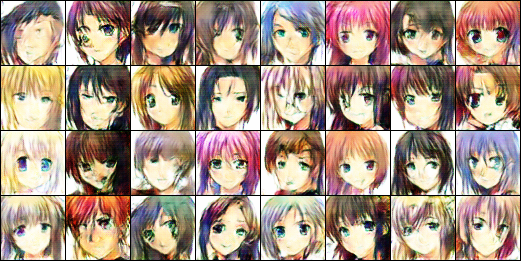

In [22]:
fig = px.imshow(np.transpose(utils.make_grid(imgs.to(device)[:32], padding=1, normalize=True).cpu(),(1,2,0)),width=1000, height=500)
fig.show()